In [3]:
from ocp.ocpmodels.datasets import SinglePointLmdbDataset
from ase import Atoms
from ase.constraints import FixAtoms
from ase.io import write
import ase
# from ase_notebook import AseView, ViewConfig, get_example_atoms
import numpy as np
import pandas as pd
import os
from ase.geometry.analysis import Analysis
import matplotlib.pyplot as plt
import torch
import networkx as nx

/tmp/ipykernel_15008/2841056455.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [17]:
import sys
print(sys.prefix)

/home/deva/miniconda3/envs/mof_env


In [ ]:
# pip install alabaster==0.7.13 anyio argon2-cffi argon2-cffi-bindings arrow ase ase-notebook==0.3.2 asttokens async-lru attrs==19.3.0 Babel backcall beautifulsoup4 bleach blinker Brotli cached-property certifi==2022.12.7 cffi charset-normalizer==2.1.1 click colorama comm contourpy cycler debugpy decorator defusedxml docutils==0.20.1 entrypoints exceptiongroup executing fastjsonschema filelock==3.9.0 Flask fonttools fqdn fsspec==2023.4.0 idna==3.4 imagesize==1.4.1 importlib-metadata importlib-resources==1.5.0 ipydatawidgets ipykernel ipython ipython-genutils==0.2.0 ipywidgets isoduration itsdangerous jedi Jinja2 joblib==1.3.2 json5 jsonpointer jsonschema jupyter-events jupyter-lsp jupyter_client jupyter_core jupyter_server jupyter_server_terminals jupyterlab jupyterlab-widgets jupyterlab_pygments jupyterlab_server kiwisolver lmdb==1.4.1 lxml==4.9.3 MarkupSafe matplotlib matplotlib-inline mistune mpmath==1.3.0 munkres==1.1.4 nbclient nbconvert nbformat nbsphinx==0.9.3 nest-asyncio networkx==3.0 notebook notebook_shim numpy==1.24.1 orjson==3.9.10 overrides packaging pandas==2.0.3 pandocfilters parso pickleshare Pillow pkgutil_resolve_name platformdirs pooch prometheus-client prompt-toolkit psutil pure-eval pycparser Pygments pyparsing pyrsistent PySocks python-dateutil python-json-logger pythreejs pytz pywin32==306 pywinpty PyYAML pyzmq requests==2.28.1 rfc3339-validator rfc3986-validator scikit-learn==1.3.2 scipy==1.10.1 Send2Trash six sniffio snowballstemmer==2.2.0 soupsieve Sphinx==7.1.2 sphinxcontrib-applehelp==1.0.4 sphinxcontrib-devhelp==1.0.2 sphinxcontrib-htmlhelp==2.0.1 sphinxcontrib-jsmath==1.0.1 sphinxcontrib-qthelp==1.0.3 sphinxcontrib-serializinghtml==1.1.5 stack-data svgutils svgwrite sympy==1.12 terminado threadpoolctl==3.2.0 tinycss2 tomli torch==2.1.2+cu118 torch-cluster==1.6.3+pt21cu118 torch-scatter==2.1.2+pt21cu118 torch-sparse==0.6.18+pt21cu118 torch-spline-conv==1.2.2+pt21cu118 torch_geometric==2.4.0 torchaudio==2.1.2+cu118 torchvision==0.16.2+cu118 tornado tqdm==4.66.1 traitlets traittypes types-python-dateutil typing-utils typing_extensions==4.4.0 tzdata==2023.3 unicodedata2 uri-template urllib3==1.26.13 wcwidth webcolors webencodings websocket-client Werkzeug widgetsnbextension win-inet-pton zipp 

In [4]:
dataset = SinglePointLmdbDataset({"src" : "/zfs/d4/prathit.chatterjee/Shaz/s2ef/train/00000.lmdb"})
# is2r\\train\\00001.lmdb
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
data = dataset[0]

/home2/shaz.ajmal/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3553: UserWarning: SinglePointLmdbDataset is deprecated and will be removed in the future.Please use 'LmdbDataset' instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
dataset[0]

Data(pos=[391, 3], cell=[1, 3, 3], atomic_numbers=[391], natoms=391, tags=[391], y=-0.6637115200001062, force=[391, 3], fixed=[391], raw_y=-2798.43559189, nco2=1, nh2o=2, nads=3, sid=[1], name='AVIPAX_0.04_0_w_CO2_2H2O_1', fid=[1], supercell=[3], oms=False, defective=True)

In [6]:
cell = np.array(torch.squeeze(data.cell, dim=0)).flatten().astype(str)
cell_string = '[ ['
for id, element in enumerate(cell):
    cell_string += (element + '] ,')
    if (id+1)%3 == 0:
        cell_string = cell_string[:-1]
        cell_string.replace(' ','')
        cell_string += '], '
        cell_string += '[ '      
    cell_string += '['  
cell_string = cell_string[:-5]
cell_string

'[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[14.143733] ,[0.0] ], [ [0.12586133] ,[-12.135651] ,[51.656994] ]'

In [7]:
supercell = data.supercell.astype(str)
supercell_string = '['
for element in supercell:
    supercell_string += element + ' '
supercell_string = supercell_string[:-1]
supercell_string = supercell_string + ']'

In [8]:
force1 = data.force[:,0].tolist()
force2 = data.force[:,1].tolist()
force3 = data.force[:,2].tolist()

x = data.pos[:,0].tolist()
y = data.pos[:,1].tolist()
z = data.pos[:,2].tolist()

In [9]:
node_features = pd.DataFrame({'name':data.name,'sid':data.sid.tolist()[0],'x':x,'y':y,'z':z,'atomic_numbers': data.atomic_numbers.tolist(), 
                              'cell':cell_string, 'natoms': data.natoms, 'tags': data.tags.tolist(), 'fixed_atoms': FixAtoms(mask=data.fixed.tolist()),
                             'y':data.y,'fixed':data.fixed.tolist(), 'force1':force1, 'force2':force2, 'force3':force3,
                             'raw_y':data.raw_y, 'n_co2':data.nco2, 'n_h2o':data.nh2o, 'nads':data.nads,
                             'fid':data.fid.tolist()[0], 'supercell':supercell_string, 'oms':data.oms, 
                             'defective':data.defective})
node_features.head()

,name,sid,x,y,z,atomic_numbers,cell,natoms,tags,fixed_atoms,...,force2,force3,raw_y,n_co2,n_h2o,nads,fid,supercell,oms,defective
0,AVIPAX_0.04_0_w_CO2_2H2O_1,510,7.783031,-0.663712,42.577244,12.0,"[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[...",391,0,FixAtoms(indices=[]),...,-0.104116,-0.022097,-2798.435592,1,2,3,0,[1 1 1],False,True
1,AVIPAX_0.04_0_w_CO2_2H2O_1,510,8.052136,-0.663712,47.951122,12.0,"[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[...",391,0,FixAtoms(indices=[]),...,0.049936,-0.047710,-2798.435592,1,2,3,0,[1 1 1],False,True
2,AVIPAX_0.04_0_w_CO2_2H2O_1,510,9.103202,-0.663712,3.842764,12.0,"[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[...",391,0,FixAtoms(indices=[]),...,-0.001391,0.007993,-2798.435592,1,2,3,0,[1 1 1],False,True
3,AVIPAX_0.04_0_w_CO2_2H2O_1,510,8.843587,-0.663712,9.213542,12.0,"[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[...",391,0,FixAtoms(indices=[]),...,-0.000605,0.001955,-2798.435592,1,2,3,0,[1 1 1],False,True
4,AVIPAX_0.04_0_w_CO2_2H2O_1,510,2.256187,-0.663712,47.805450,12.0,"[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[...",391,0,FixAtoms(indices=[]),...,0.057758,0.078920,-2798.435592,1,2,3,0,[1 1 1],False,True


In [10]:
# location of CO2 
location_h2o = node_features[node_features['tags'] == 1]
location_h2o

,name,sid,x,y,z,atomic_numbers,cell,natoms,tags,fixed_atoms,...,force2,force3,raw_y,n_co2,n_h2o,nads,fid,supercell,oms,defective
266,AVIPAX_0.04_0_w_CO2_2H2O_1,510,10.115461,-0.663712,43.187832,6.0,"[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[...",391,1,FixAtoms(indices=[]),...,0.364923,-0.158026,-2798.435592,1,2,3,0,[1 1 1],False,True
387,AVIPAX_0.04_0_w_CO2_2H2O_1,510,9.123399,-0.663712,43.057140,8.0,"[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[...",391,1,FixAtoms(indices=[]),...,0.767487,-0.004322,-2798.435592,1,2,3,0,[1 1 1],False,True
388,AVIPAX_0.04_0_w_CO2_2H2O_1,510,11.107408,-0.663712,43.319038,8.0,"[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[...",391,1,FixAtoms(indices=[]),...,-1.081169,0.207111,-2798.435592,1,2,3,0,[1 1 1],False,True


In [11]:
# location of H2O 
location_co2 = node_features[node_features['tags'] == 2]
location_co2

,name,sid,x,y,z,atomic_numbers,cell,natoms,tags,fixed_atoms,...,force2,force3,raw_y,n_co2,n_h2o,nads,fid,supercell,oms,defective
101,AVIPAX_0.04_0_w_CO2_2H2O_1,510,9.479473,-0.663712,44.103191,1.0,"[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[...",391,2,FixAtoms(indices=[]),...,-0.573319,0.338631,-2798.435592,1,2,3,0,[1 1 1],False,True
102,AVIPAX_0.04_0_w_CO2_2H2O_1,510,10.774419,-0.663712,43.633114,1.0,"[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[...",391,2,FixAtoms(indices=[]),...,-0.285563,0.083602,-2798.435592,1,2,3,0,[1 1 1],False,True
103,AVIPAX_0.04_0_w_CO2_2H2O_1,510,1.118792,-0.663712,44.391956,1.0,"[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[...",391,2,FixAtoms(indices=[]),...,-0.869329,0.102691,-2798.435592,1,2,3,0,[1 1 1],False,True
104,AVIPAX_0.04_0_w_CO2_2H2O_1,510,1.743731,-0.663712,44.176029,1.0,"[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[...",391,2,FixAtoms(indices=[]),...,0.316653,-0.061010,-2798.435592,1,2,3,0,[1 1 1],False,True
389,AVIPAX_0.04_0_w_CO2_2H2O_1,510,9.823480,-0.663712,43.588173,8.0,"[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[...",391,2,FixAtoms(indices=[]),...,0.946404,-0.421694,-2798.435592,1,2,3,0,[1 1 1],False,True
390,AVIPAX_0.04_0_w_CO2_2H2O_1,510,0.911768,-0.663712,44.382141,8.0,"[ [11.1177] ,[0.0] ,[0.0] ], [ [0.11493808] ,[...",391,2,FixAtoms(indices=[]),...,0.672256,0.145617,-2798.435592,1,2,3,0,[1 1 1],False,True


In [19]:
lmdb_directory = "/zfs/d4/prathit.chatterjee/Shaz/s2ef/train/"
atomic_numbers_list = []

for lmdb_file in sorted(os.listdir(lmdb_directory)):
    if lmdb_file.endswith(".lmdb"):
        lmdb_path = os.path.join(lmdb_directory, lmdb_file)
        dataset = SinglePointLmdbDataset({"src" : lmdb_path})
        data = dataset[0]
        atomic_numbers = data.atomic_numbers.unique().tolist()

        for i in atomic_numbers:
            if i not in atomic_numbers_list:
                atomic_numbers_list.append(i)

atomic_numbers_list

/home2/shaz.ajmal/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3553: UserWarning: SinglePointLmdbDataset is deprecated and will be removed in the future.Please use 'LmdbDataset' instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


KeyboardInterrupt: 

In [12]:
atomic_numbers = {
    'H': 1.0, 'C': 6.0, 'N': 7.0, 'O': 8.0, 'Mg': 12.0, 'Ni': 28.0, 'Cd': 48.0, 'Cu': 29.0, 'Zn': 30.0,
    'Fe': 26.0, 'P': 15.0, 'S': 16.0, 'Mn': 25.0, 'Au': 79.0, 'Al': 13.0, 'Cl': 17.0, 'Co': 27.0, 'Ag': 47.0,
    'Si': 14.0, 'Ca': 20.0, 'Br': 35.0, 'Cr': 24.0, 'As': 33.0, 'Tb': 65.0, 'La': 57.0, 'Na': 11.0, 'B': 5.0,
    'I': 53.0, 'Ga': 31.0, 'Ce': 58.0, 'F': 9.0, 'Be': 4.0, 'Li': 3.0, 'Sr': 38.0, 'Mo': 42.0, 'Bi': 83.0,
    'Sc': 21.0, 'V': 23.0, 'Y': 39.0, 'Ba': 56.0, 'Pt': 78.0, 'Gd': 64.0
}

atoms_data = {}

for i in range(len(node_features)):
    atoms_data[f'Atom{i}'] = {'atomic_number':node_features['atomic_numbers'][i], 'coordinates': (node_features['x'][i],node_features['y'][i],node_features['z'][i])}

In [22]:
atoms_data

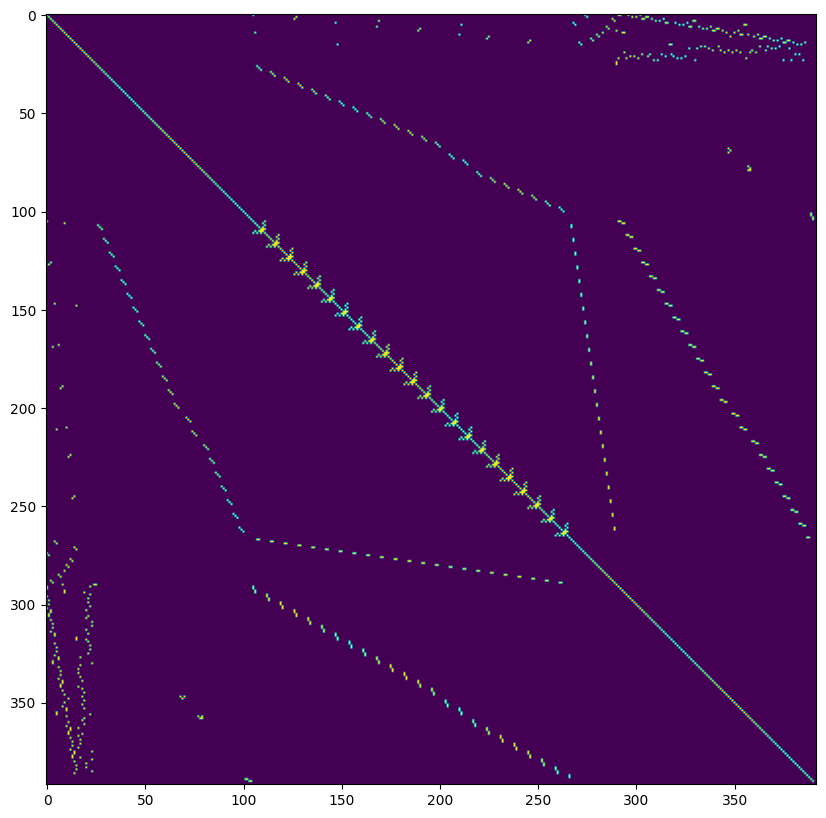

In [13]:
atoms = Atoms(numbers=data.atomic_numbers.tolist(), positions=data.pos.tolist(), tags=data.tags.tolist(), cell=data.cell.numpy().reshape(3,3), constraint=FixAtoms(mask=data.fixed.tolist()), pbc=[True,True,True])

ana = Analysis(atoms)
# ana.adjacency_matrix, ana.get_bonds('C', 'O')
adj_mat = ana.adjacency_matrix

temp = np.zeros((392, 392), dtype=np.uint8)
for i in adj_mat[0].keys(): 
    temp[i[0], i[1]] = 1
    temp[i[1], i[0]] = 1

plt.figure(figsize=(10,10))
plt.imshow(temp)
plt.show()

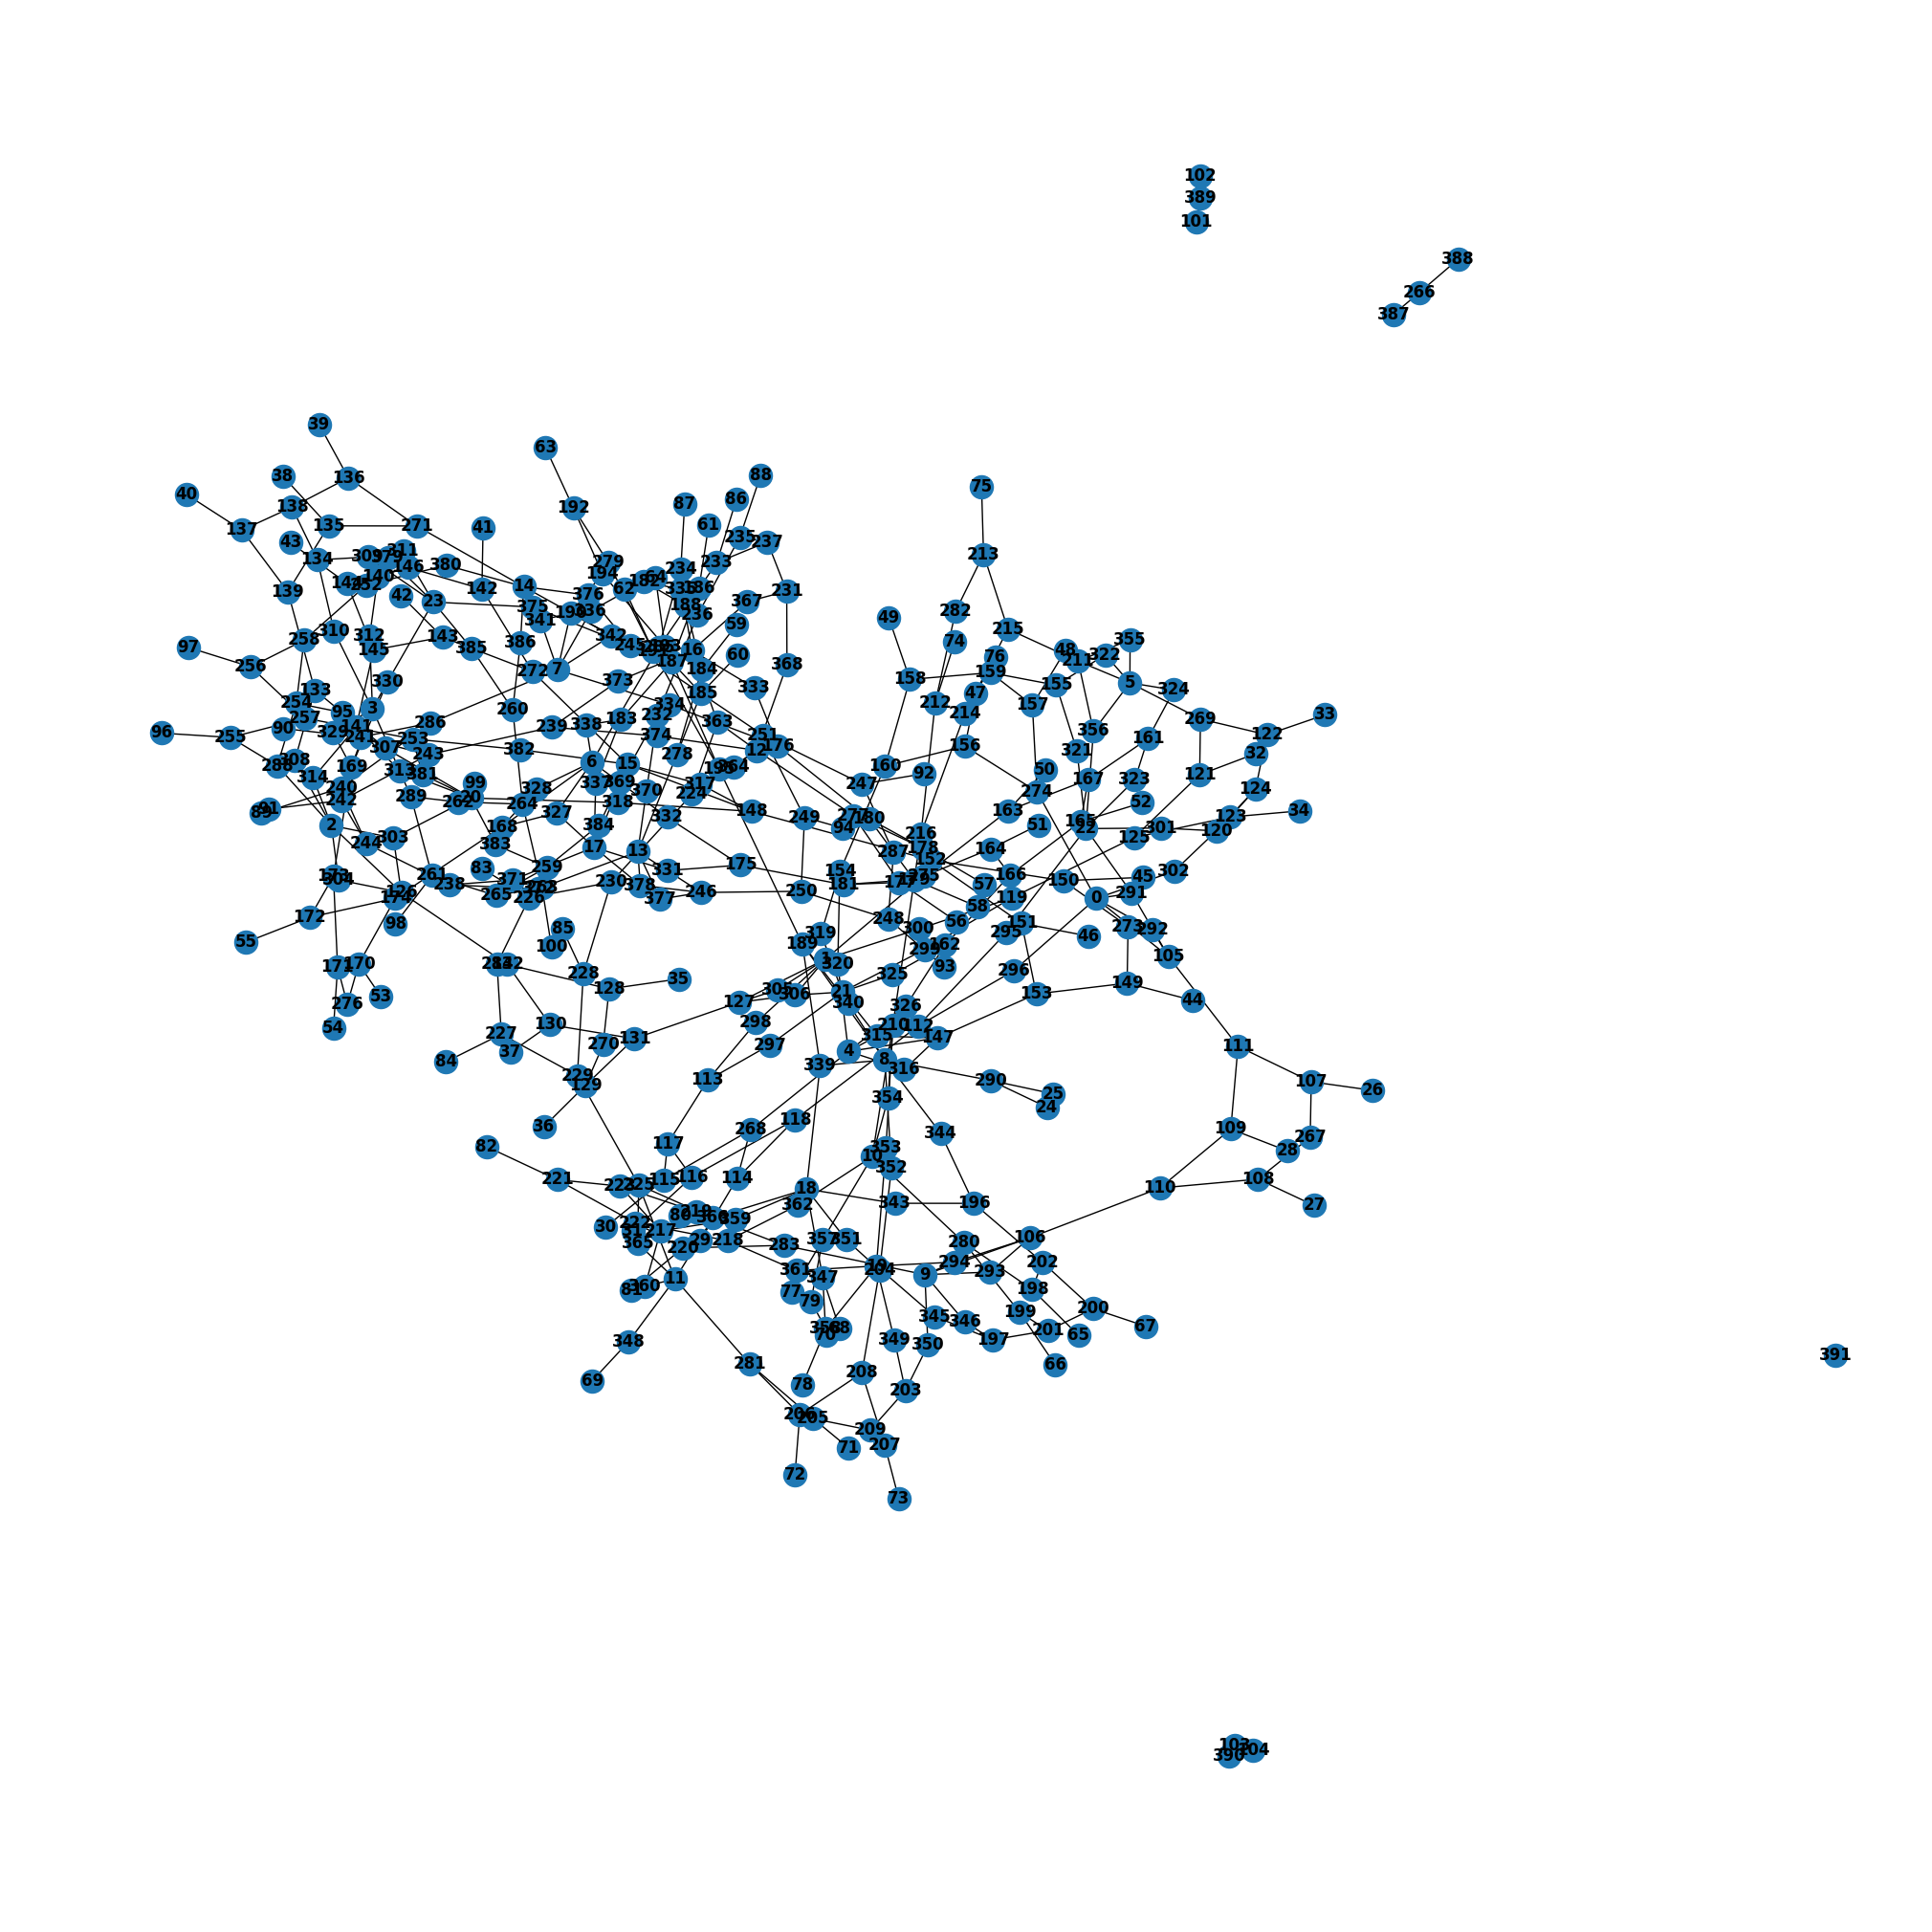

In [14]:
G = nx.Graph()

num_nodes = len(temp)
G.add_nodes_from(range(num_nodes))

# Add edges from the adjacency matrix
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if temp[i, j] == 1:
            G.add_edge(i, j)

pos = nx.spring_layout(G)

# Visualization (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
nx.draw(G, pos, font_weight='bold', with_labels=True)
plt.show()

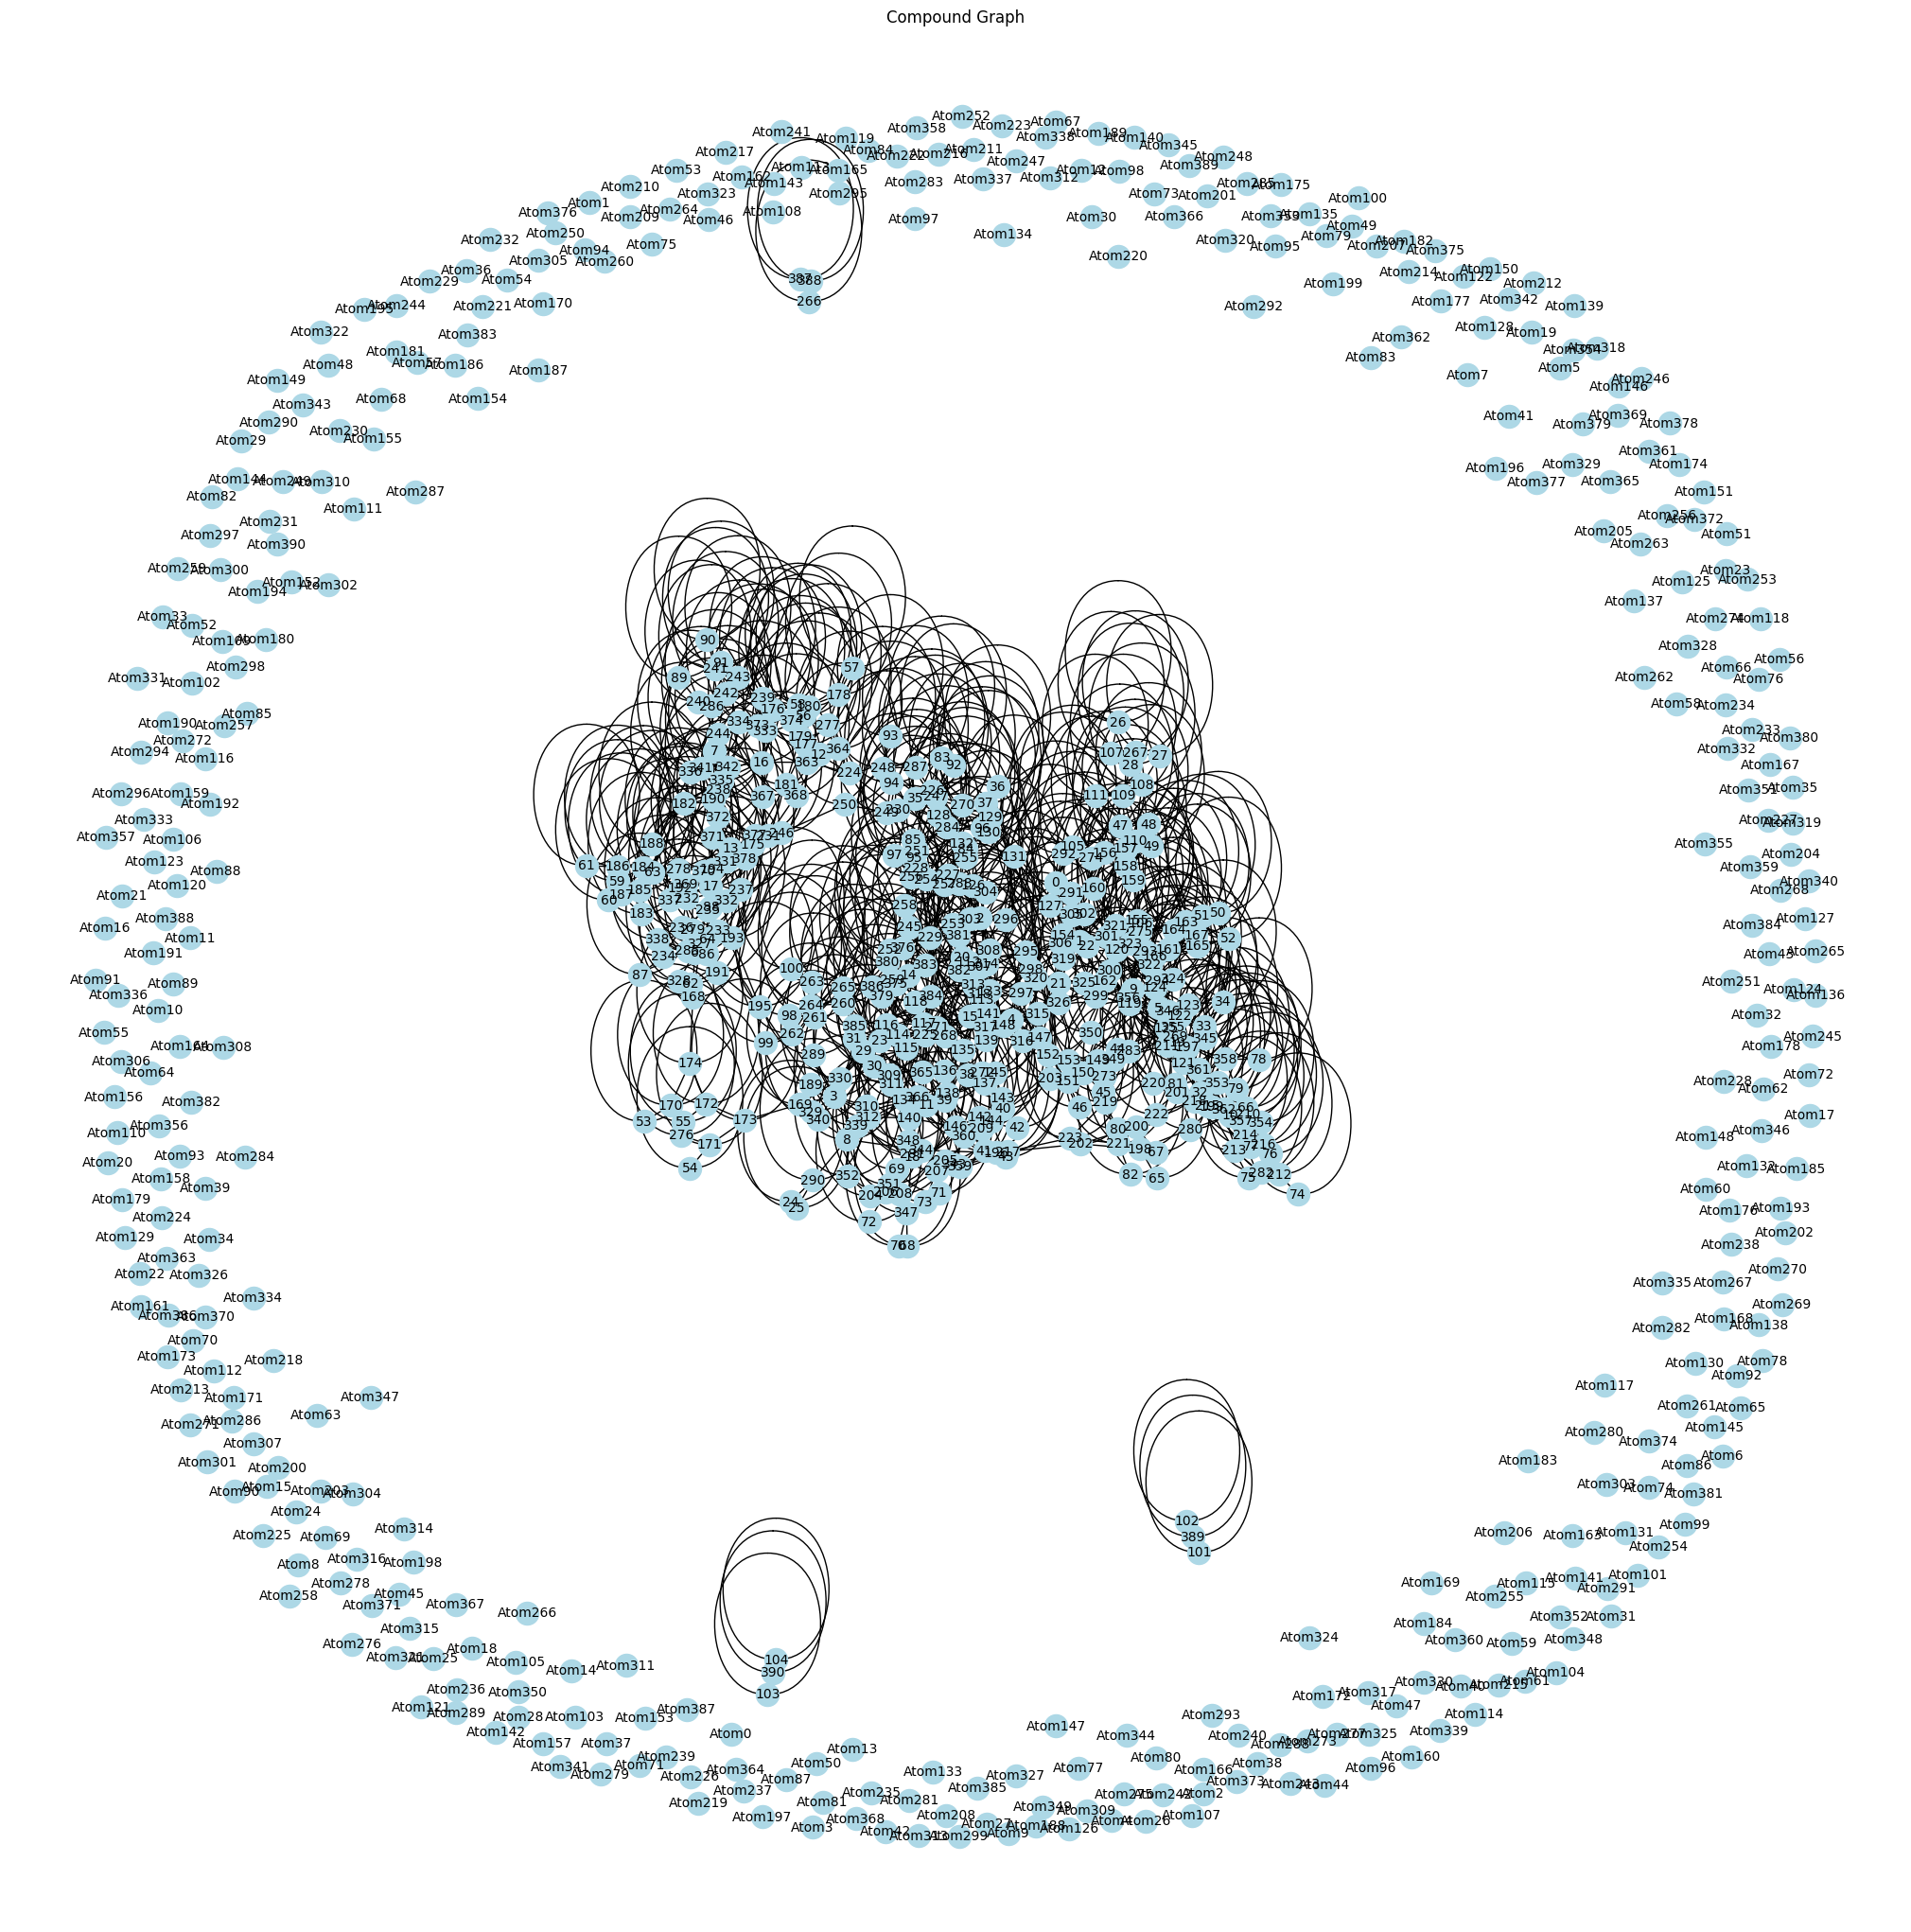

In [15]:
import networkx as nx

compound_graph = nx.Graph()

for atom,data in atoms_data.items():
    compound_graph.add_node(atom, atomic_number=data['atomic_number'], coordinates=data['coordinates'])

compound_graph.add_edges_from([key for key,value in adj_mat[0].items()])

plt.figure(figsize=(20,20))
pos = nx.spring_layout(compound_graph)
nx.draw(compound_graph, pos, with_labels=True, node_color='lightblue', font_size=10, font_color='black')
plt.title('Compound Graph')
plt.show()

In [16]:
def lmdb_to_cif(lmdb_data):
    
    positions = lmdb_data['pos']
    cell_parameters = lmdb_data['cell'][0]
    atomic_numbers = lmdb_data['atomic_numbers']

    atoms = Atoms(positions=positions, numbers=atomic_numbers, cell=cell_parameters)

    cif_filename = f"MOF_train/{lmdb_data['name']}.cif"
        
    write(cif_filename, atoms, format='cif')

    return cif_filename

# cif_file = lmdb_to_cif(lmdb_data)
# print(f"CIF file '{cif_file}' generated succesfully")

lmdb_directory = "/zfs/d4/prathit.chatterjee/Shaz/s2ef/train/"

for lmdb_file in sorted(os.listdir(lmdb_directory)):
    if lmdb_file.endswith(".lmdb"):
        lmdb_path = os.path.join(lmdb_directory, lmdb_file)
        dataset = SinglePointLmdbDataset({"src" : lmdb_path})
        data = dataset[0]

        lmdb_data = {
            'pos': data.pos.tolist(),
            'cell': data.cell.tolist(),
            'atomic_numbers': data.atomic_numbers,
            'name': data.name
        }
        cif_file = lmdb_to_cif(lmdb_data)
        print(f"CIF file '{cif_file}' generated succesfully")

/home2/shaz.ajmal/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3553: UserWarning: SinglePointLmdbDataset is deprecated and will be removed in the future.Please use 'LmdbDataset' instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


CIF file 'MOF_train/AVIPAX_0.04_0_w_CO2_2H2O_1.cif' generated succesfully
CIF file 'MOF_train/DOYLEI_0.05_1_w_CO2_2H2O_1.cif' generated succesfully
CIF file 'MOF_train/ACAJIZ_0.04_0_w_CO2_2H2O_1.cif' generated succesfully
CIF file 'MOF_train/ASADAA_0.06_1_w_CO2_2H2O_1.cif' generated succesfully
CIF file 'MOF_train/AMILUE_0.08_0_w_CO2_2H2O_1.cif' generated succesfully
CIF file 'MOF_train/DUXZIG01_0.03_0_w_CO2_2H2O_1.cif' generated succesfully
CIF file 'MOF_train/BUVYIB_0.08_0_w_CO2_2H2O_1.cif' generated succesfully
CIF file 'MOF_train/IJEXIF_0.06_0_w_CO2_2H2O_1.cif' generated succesfully
CIF file 'MOF_train/DEFKUU_0.12_0_w_CO2_2H2O_1.cif' generated succesfully
CIF file 'MOF_train/AQUDIB_0.11_0_w_CO2_2H2O_1.cif' generated succesfully
CIF file 'MOF_train/FAQGIP_0.06_1_w_CO2_2H2O_1.cif' generated succesfully
CIF file 'MOF_train/HEXNII_0.16_0_w_CO2_2H2O_1.cif' generated succesfully
CIF file 'MOF_train/ESASAU_0.06_0_w_CO2_2H2O_1.cif' generated succesfully
CIF file 'MOF_train/CAXVOO_0.16_0_w_

In [ ]:
# from moftransformer.examples import example_path
# # type(example_path['root_cif'])
# print(example_path['root_cif'])

# import json

# with open('/home/shazam/miniconda3/envs/mof_env/lib/python3.10/site-packages/moftransformer/examples/raw/raw_example.json', 'r') as f:
#     data = json.load(f)

# type(data['msp+N624+E8'])
import os

new_dict = {}

for file in sorted(os.listdir('/home/shazam/MOF/examples/raw/')):
    new_dict[file[:-4]] = 1.0

with open("/home/shazam/MOF/examples/raw/raw_examples.json", "w") as outfile: 
    json.dump(new_dict, outfile)

In [1]:
import torch
print(torch.cuda.is_available())

False


In [19]:
from moftransformer.examples import example_path
from moftransformer.utils import prepare_data
from moftransformer.database.coremof import raw

# Get example path
# root_cifs = example_path['root_cif']
# root_dataset = example_path['root_dataset']
# downstream = example_path['downstream']

root_cifs = '/home/shazam/MOF/examples/raw'
root_dataset = '/home/shazam/MOF/examples/dataset'
downstream = 'examples'

train_fraction = 0.8  # default value
test_fraction = 0.1   # default value

# Run prepare data
prepare_data(root_cifs, root_dataset, downstream=downstream, 
             train_fraction=train_fraction, test_fraction=test_fraction)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 480/480 [00:00<00:00, 10754.22it/s]


In [ ]:
import moftransformer
from moftransformer.examples import example_path

# data root and downstream from example
# root_dataset = example_path['root_dataset']
# downstream = example_path['downstream']
# log_dir = './logs/'
root_dataset = '/home/shazam/MOF/examples/dataset'
downstream = 'examples'
log_dir = '/home/shazam/MOF/logs'
# load_path = "pmtransformer" (default)

# kwargs (optional)
max_epochs = 7
batch_size = 8
mean = 0
std = 1


moftransformer.run(root_dataset, downstream, log_dir=log_dir,                   
                   max_epochs=max_epochs, batch_size=batch_size,
                   mean=mean, std=std)

Global seed set to 0


load model : /home/shazam/miniconda3/envs/mof_env/lib/python3.10/site-packages/moftransformer/database/pmtransformer.ckpt
num_device 1


/home/shazam/miniconda3/envs/mof_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:159: UserWarning: You passed `deterministic=True` and `benchmark=True`. Note that PyTorch ignores torch.backends.cudnn.deterministic=True when torch.backends.cudnn.benchmark=True.
  rank_zero_warn(
/home/shazam/miniconda3/envs/mof_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:712: UserWarning: You passed `Trainer(accelerator='cpu', precision=16)` but native AMP is not supported on CPU. Using `precision='bf16'` instead.
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
Loading `train_dataloader` to estimate number of stepping batches.

   | Name    

read /home/shazam/MOF/examples/dataset/train_examples.json...
read /home/shazam/MOF/examples/dataset/val_examples.json...
max_epochs: 7 | max_steps: 336 | warmup_steps : 16 | weight_decay : 0.01 | decay_power : 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

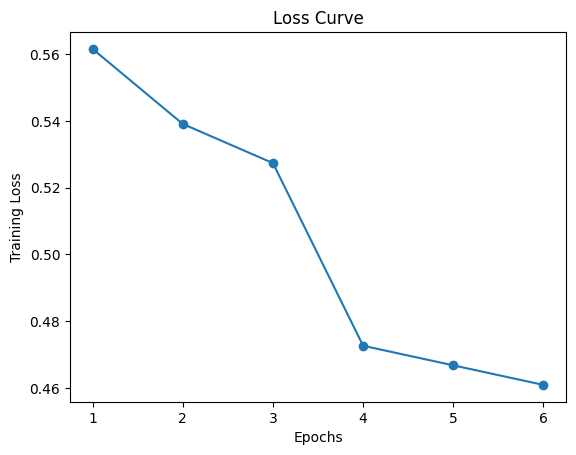

In [3]:
import matplotlib.pyplot as plt

training_losses = [0.56152, 0.53906, None, 0.52734, 0.47266, 0.46680, 0.46094]

# Remove None values from training_losses
training_losses = [loss for loss in training_losses if loss is not None]

plt.plot(range(1, len(training_losses) + 1), training_losses, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Loss Curve')

# Show the plot
plt.show()

In [14]:
import pandas as pd
import numpy as np

train_accuracy_df = pd.DataFrame({'cif_id':['sml+N696+E182',
'zzz+N96+N373+E34',
'mok+N109+E146',
'msp+N624+E8',
'ukg+N387+E203',
'vna+N650+E120',
'vmk+N489+E8',
'fee+N254+E185',
'mrc+N568+N190+E116+E77'
],
'regression_logits': [0.96875,
0.9765625,
0.8046875,
1.0625,
1.109375,
1.0625,
0.95703125,
0.9140625,
0.96484375,
]})

train_accuracy_df['regression_labels'] = 1
train_accuracy_df['diff'] = abs(train_accuracy_df['regression_labels'] - train_accuracy_df['regression_logits'])
accuracy = 1 - np.sum(train_accuracy_df['diff']) / len(train_accuracy_df['diff'])
accuracy

0.9279513888888888

In [ ]:
-

In [7]:
from pathlib import Path
import moftransformer
from moftransformer.examples import example_path

root_dataset = example_path['root_dataset']
downstream = example_path['downstream']

# Get ckpt file
seed = 0               # default seeds
version = 0            # version for model. It increases with the number of trains

# For version > 2.1.1, best.ckpt exists
checkpoint = 'best'    # Epochs where the model is stored. 
save_dir = 'result/'
log_dir = './logs/'

# optional keyword
mean = 0
std = 1

load_path = Path(log_dir) / f'pretrained_mof_seed{seed}_from_pmtransformer/version_{version}/checkpoints/{checkpoint}.ckpt'

if not load_path.exists():
    raise ValueError(f'load_path does not exists. check path for .ckpt file : {load_path}')

moftransformer.test(root_dataset, load_path, downstream=downstream,
                   save_dir=save_dir, mean=mean, std=std)

ValueError: load_path does not exists. check path for .ckpt file : logs/pretrained_mof_seed0_from_pmtransformer/version_0/checkpoints/best.ckpt

In [5]:
from pathlib import Path
import moftransformer
from moftransformer.examples import example_path

root_dataset = example_path['root_dataset']
downstream = example_path['downstream']

# Get ckpt file
log_dir = './logs/'    # same directory make from training
seed = 0               # default seeds
version = 0            # version for model. It increases with the number of trains
checkpoint = 'best'    # Epochs where the model is stored. 
mean = 0
std = 1

# load_path = Path(log_dir) / f'pretrained_mof_seed{seed}_from_pmtransformer/version_{version}/checkpoints/{checkpoint}.ckpt'
load_path = Path(log_dir) / f'pretrained_mof_seed{seed}_from_pmtransformer/version_1/checkpoints/{checkpoint}.ckpt'

if not load_path.exists():
    raise ValueError(f'load_path does not exists. check path for .ckpt file : {load_path}')
    
moftransformer.predict(
    root_dataset, load_path=load_path, downstream=downstream, split='all', mean=mean, std=std
)

Global seed set to 0


load model : logs/pretrained_mof_seed0_from_pmtransformer/version_1/checkpoints/best.ckpt


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


read /home/shazam/miniconda3/envs/mof_env/lib/python3.10/site-packages/moftransformer/examples/dataset/train_example.json...
read /home/shazam/miniconda3/envs/mof_env/lib/python3.10/site-packages/moftransformer/examples/dataset/val_example.json...
read /home/shazam/miniconda3/envs/mof_env/lib/python3.10/site-packages/moftransformer/examples/dataset/test_example.json...


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

All prediction values are saved in logs/pretrained_mof_seed0_from_pmtransformer/version_1


In [5]:
from moftransformer.visualize import PatchVisualizer
from moftransformer.examples import visualize_example_path

model_path = "examples/finetuned_bandgap.ckpt" # or 'examples/finetuned_h2_uptake.ckpt'
data_path = visualize_example_path
cifname = 'MIBQAR01_FSR'

vis = PatchVisualizer.from_cifname(cifname, model_path, data_path)
vis.draw_graph()

Global seed set to 0


FileNotFoundError: [Errno 2] No such file or directory: 'examples/finetuned_bandgap.ckpt'